# Where should a drinks company run promotions?

## Executive summary
According to Wine intelligencia, the Russian wine market has experienced rampant growth at a 13% compound year rate since 2015. Also, the value spending on wine has increased at 20.9% compound year rate over the same period.  Russians are buying more wine so it is a great opportunity for wine retail to catch on to the wave and expand their sales. 

The drinks company has ran a successful wine campaign in St. Petersburg and would like to find ten similar regions to expand into.  In this report, we found the ten most similar regions are: Tver Oblast, Sverdlovsk Oblast, Kaliningrad Oblast, Yaroslavl Oblast, Chukotka Autonomous Okrug, Pskov Oblast, Primorsky Krai, Republic of Karelia, Kaluga Oblast and Novgorod Oblast.

First, we summarize how alcohol consumption has developed through time.
Next, we scale the data and apply Principal Component Analysis, before running K-means clustering.
We find that the ten regions similar to Saint Petersburg that the company might run the promotion are: 

## The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

"year" - year (1998-2016)
"region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
"wine" - sale of wine in litres by year per capita
"beer" - sale of beer in litres by year per capita
"vodka" - sale of vodka in litres by year per capita
"champagne" - sale of champagne in litres by year per capita
"brandy" - sale of brandy in litres by year per capita

In [2]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

In [236]:
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df['year'] = pd.to_datetime(df.year , format = '%Y')
df['region'] = df.region.astype('category')
df.head()

drinks = ['wine' , 'beer' , 'vodka' , 'champagne', 'brandy']

In [237]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   year       1615 non-null   datetime64[ns]
 1   region     1615 non-null   category      
 2   wine       1552 non-null   float64       
 3   beer       1557 non-null   float64       
 4   vodka      1554 non-null   float64       
 5   champagne  1552 non-null   float64       
 6   brandy     1549 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(5)
memory usage: 80.1 KB


,count,mean,std,min,25%,50%,75%,max
wine,1552.0,5.628144,2.813208,0.10,3.575,5.40,7.3775,18.10
beer,1557.0,51.260148,25.372821,0.40,32.400,49.97,67.4000,207.30
vodka,1554.0,11.818694,5.128806,0.05,8.300,11.50,15.0000,40.60
champagne,1552.0,1.313177,0.797956,0.10,0.800,1.20,1.6650,5.56
brandy,1549.0,0.526998,0.400201,0.00,0.200,0.40,0.7000,2.30


In [238]:
missing_df = df[df.isna().any(axis=1)]
print(missing_df.region.value_counts() , df.region.value_counts())

Chechen Republic          19
Sevastopol                16
Republic of Crimea        16
Republic of Ingushetia    15
Altai Krai                 0
                          ..
Kurgan Oblast              0
Krasnoyarsk Krai           0
Krasnodar Krai             0
Kostroma Oblast            0
Zabaykalsky Krai           0
Name: region, Length: 85, dtype: int64 Altai Krai                  19
Republic of Karelia         19
Sakha (Yakutia) Republic    19
Saint Petersburg            19
Ryazan Oblast               19
                            ..
Kurgan Oblast               19
Krasnoyarsk Krai            19
Krasnodar Krai              19
Kostroma Oblast             19
Zabaykalsky Krai            19
Name: region, Length: 85, dtype: int64


There are 4 regions in the dataset with many missing observations:  
* Chechen Republic
* Sevastopol
* Republic of Crimea
* Republic of Ingushetia  

We will remove data for these regions.

In [246]:
filter = df.region.isin( ['Republic of Ingushetia',
 'Republic of Crimea',
 'Sevastopol',
 'Chechen Republic'])
repaired_df = df[~filter].copy()
repaired_df['region'] = repaired_df.region.cat.remove_unused_categories()
# repaired_df.region.value_counts()
print(len(repaired_df), len(df))

1539 1615


3.Exploratory data analisys
First I will look for the data distribution and its development through time and comparing with Saint Petersburg data.

In [7]:
sp_df = df[df.region == 'Saint Petersburg']
nsp_df = df[df.region != 'Saint Petersburg']

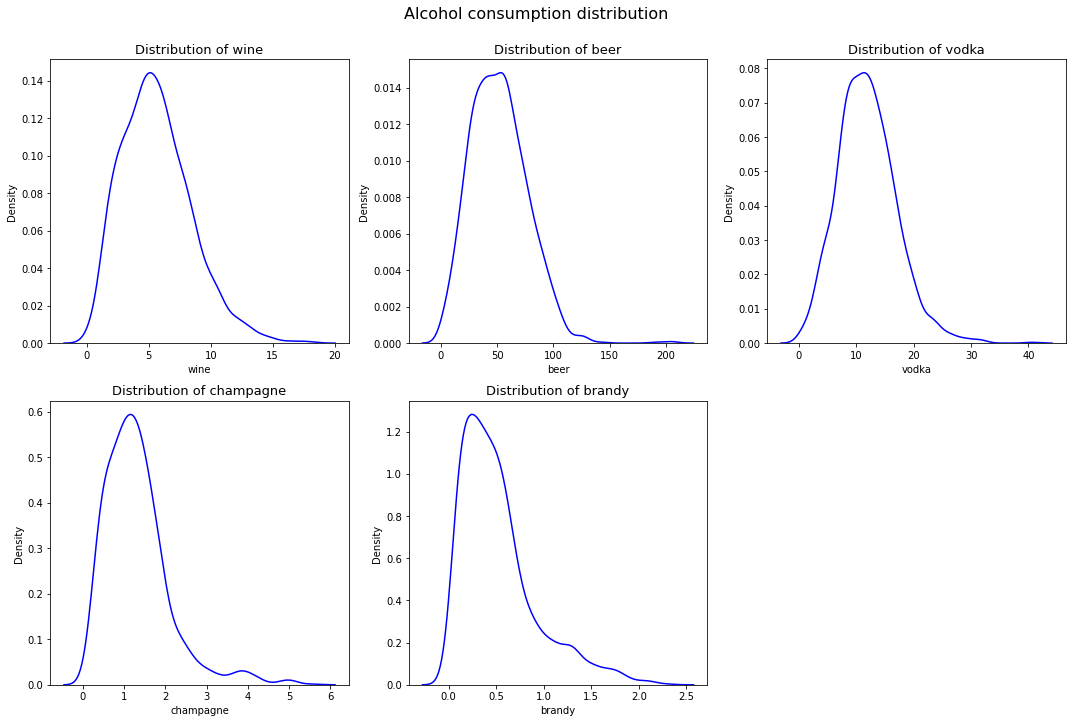

In [8]:
#Looking for distributions 
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(drinks):
    plt.subplot(2,3,i+1)
    sns.kdeplot(df[col], color='blue')
    plt.title(f'Distribution of {col}', fontsize=13)
fig.suptitle('Alcohol consumption distribution',y=1, fontsize=16)
plt.tight_layout()

All the distributions display a bell shape, which is a good characteristic. Anyway, for further analysis, it would be better if a logarithmic transformation is made. It wouldn't change the characteristics of our data but it will improve the performance of the predictive model.
Skewed right

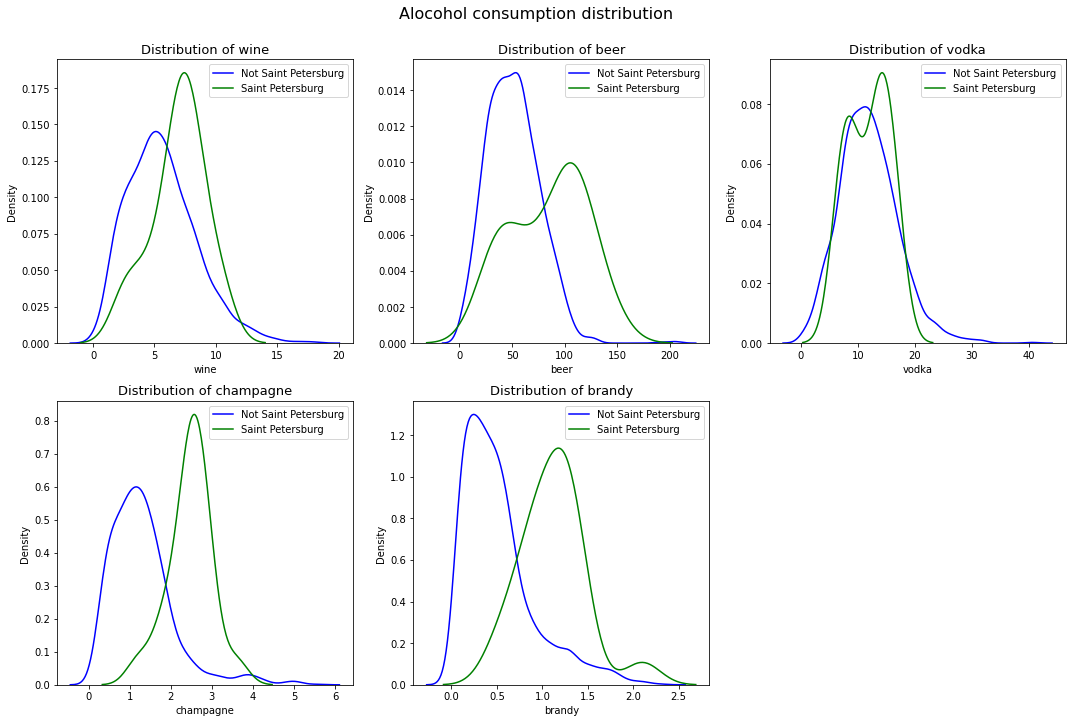

In [9]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(drinks):
    # Plot lineplot 
    plt.subplot(2,3,i+1) 
    sns.kdeplot(nsp_df[col], color='blue' , label = 'Not Saint Petersburg') 
    sns.kdeplot(sp_df[col], color = 'green' , label = 'Saint Petersburg')
    plt.title(f'Distribution of {col}', fontsize=13)
    plt.legend()
fig.suptitle('Alocohol consumption distribution',y=1, fontsize=16)
plt.tight_layout()

From these graphs, we can see that the median (average) consumption of alcohol in Saint Petersburg (blue line) is higher than other regions in Russia (green line) for all types of alcohol.  Note that the unit of consumption is litres per capita per year.

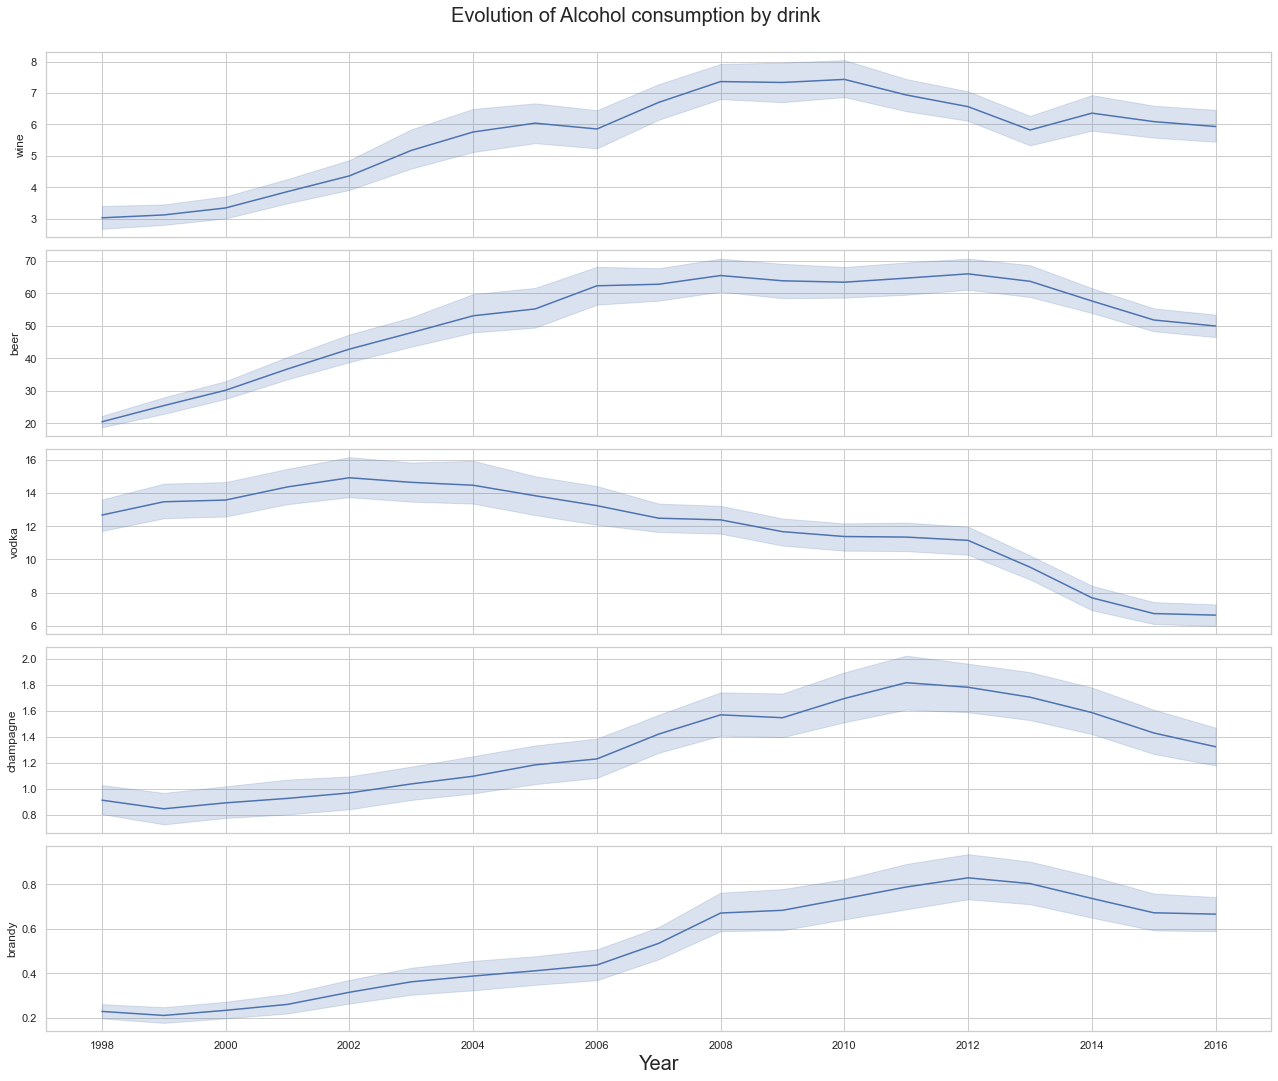

In [12]:
#Evolution Around the time all data set
fig, axs = plt.subplots(5,1,figsize=(18,15),sharex=True)
fig.suptitle('Evolution of Alcohol consumption by drink', y=1 , fontsize = 20)
for i, col in enumerate(drinks):
    sns.lineplot(x='year', y= col , data = df, ax = axs[i])
axs[4].set_xlabel('Year', fontsize=20)
plt.tight_layout()

Second I am going to look at the evolution through the time of Saint Petersburg and the other regions for separate

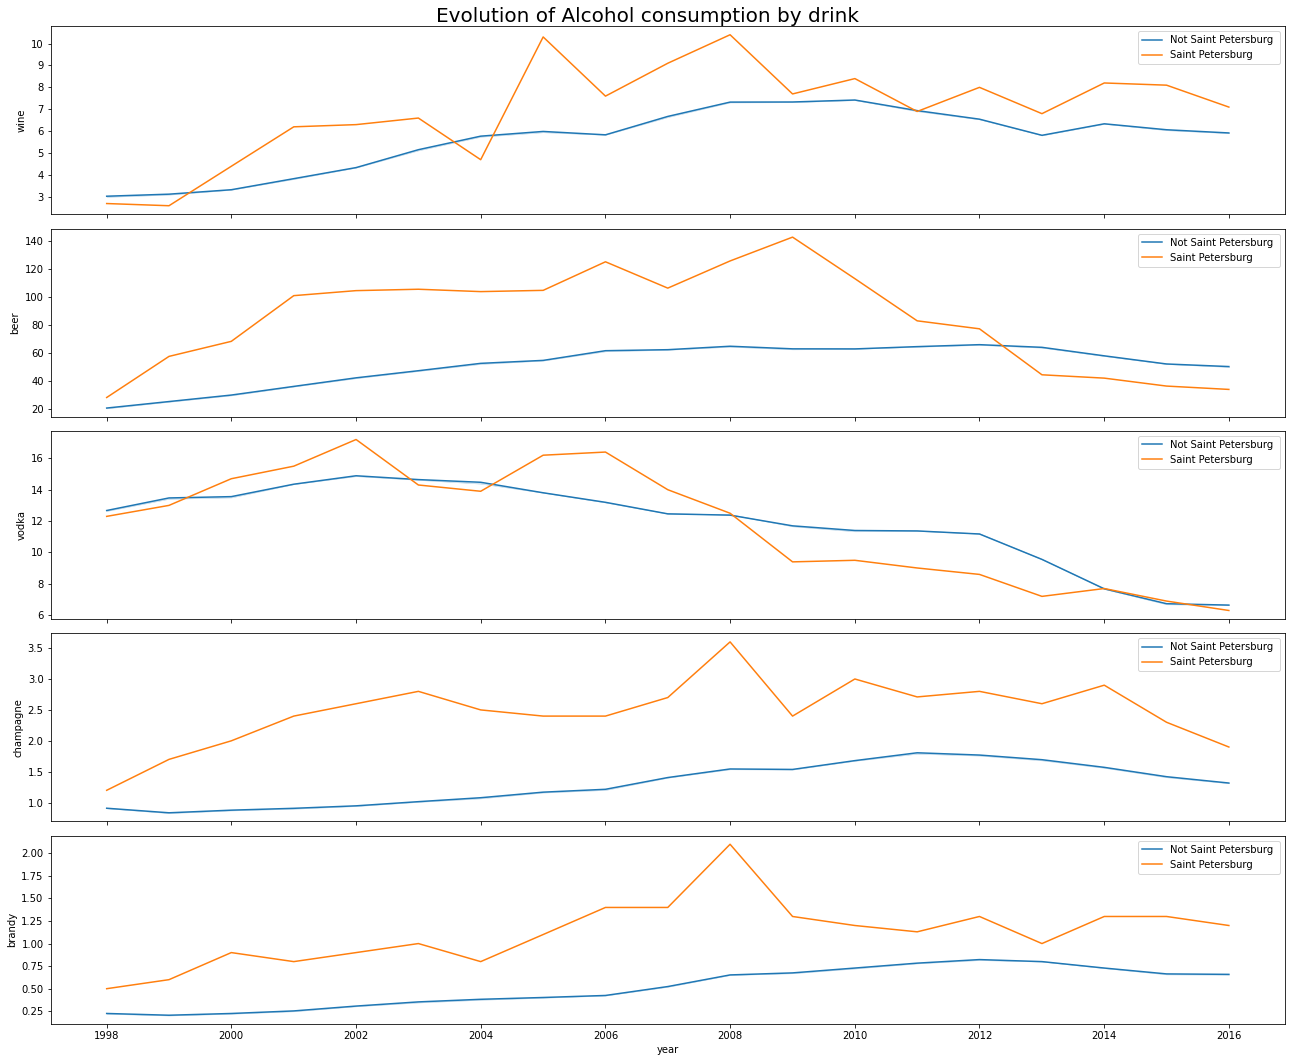

In [10]:
#Evolution Around the time Saint Petersburg and Not Saint Petersburg data
fig, axs = plt.subplots(5,1,figsize=(18,15),sharex=True)
fig.suptitle('Evolution of Alcohol consumption by drink' , fontsize = 20)
for i, col in enumerate(drinks):
    sns.lineplot(x='year', y= col , data = nsp_df, ax = axs[i] , label = 'Not Saint Petersburg ' , ci = False)
    sns.lineplot(x='year', y= col , data = sp_df, ax = axs[i], label = 'Saint Petersburg' , ci = False)
    # plt.legend()
plt.tight_layout()

Although, as we have seen before, the average alcohol consumption of Saint Petersburg is above the average alcohol consumption which does not include Saint Petersburg data, both data set show a similar trend.

For Brandy, the brandy consumption in StP grew from 1998 until 2006, where it pretty much stayed level except for an outlier in 2008.
Outside StP, brand consumption is growing steadily until 2012, after which it declined slightly.

Finally, I run a correlation of alcoholic drink consumptions, for the entire data set, non-Saint Petersburg data set, and Saint Petersburg data set.

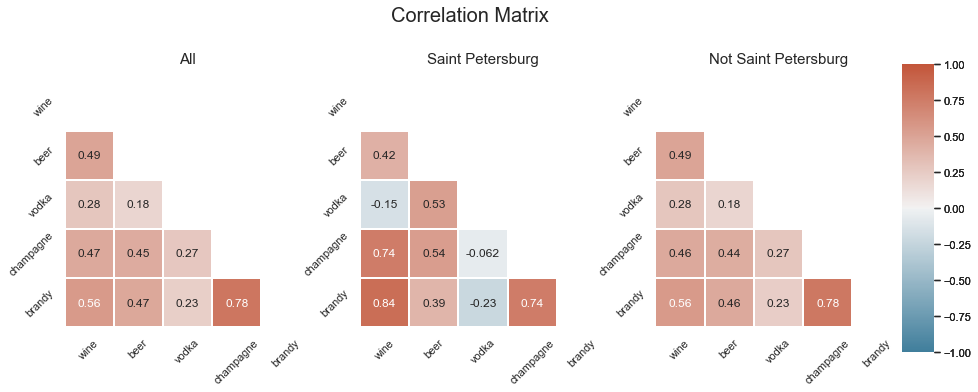

In [15]:
def mult_correlation_matrix(df1, df2, df3, data_set =['']*3):
    # Set up the matplotlib figure
    fig, axs = plt.subplots(1,3,figsize=(15, 20))                    # Set figure size
    l = [df1 , df2, df3]
    for i,df in enumerate(l):
        #Compute the correlation matrix
        corr = df.corr(method = 'pearson')

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))

    
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        cbar_ax = fig.add_axes([.9, .4, .03, .2])
        # Draw the heatmap with the mask 
        sns.heatmap(corr, 
                mask = mask, 
                cmap = cmap, 
                vmax = 1,                                      # Set scale min value
                vmin = -1,                                     # Set scale min value
                center = 0,                                    # Set scale min value
                square = True,                                 # Ensure perfect squares
                linewidths = 1.5,                              # Set linewidth between squares
                cbar_kws = {"shrink": .9},                     # Set size of color bar
                annot = True ,                                  # Include values within squares
                ax = axs[i],
                cbar_ax = cbar_ax 
                    
               );
        axs[i].tick_params(labelrotation=45)   # Rotate y labels
        axs[i].set_title(f'{data_set[i]}', size=10, y=1.05, fontsize =15);   # Set plot title and positionnsp_df.corr()
    fig.suptitle('Correlation Matrix', x=0.5 , y=0.64, fontsize = 20)

#Looking for correlation matrix
mult_correlation_matrix(df, sp_df, nsp_df , ['All', 'Saint Petersburg' , 'Not Saint Petersburg'])

Comparing the Saints Peterburg data set with the two others is possible to see that Wine consumption is strongly correlated with Brandy and Champagne consumption, which means that Wine, Champagne, and Beer tend to move in the same ways. This trend could be seen in Beer consumption but it is weaklier, and, also weakly than the correlation observe in the other data set. Finally, we can see that Vodka consumption is negatively correlated with Wine consumption, however, that effect is too weak. A good cluster analysis should recommend regions where not only the consumption per capita was similar but also the correlations.

4.Data Set
The data set is known as Data Panel, which means that you have information for a region through time. Making a cluster analysis is difficult because there isn't a clear way to cluster regions that share similar trends through time.

If we do not consider that we aren't working with a Data Panel, we could probably end in the conclusion that the best region to launch a commercial campaign apart from Saint Peterburg in 2021 is Saint Petersburg in 2016 or Altai Krai in 2005. Although if I only pick last year's information I will be ignoring too much information about the past for the regions.

So to tackle this issue, I choose to use the six last years of the Data Set  
because, if I only kept the last year and use a clustering method as KNN, there it would be too sensitive to outliers.  
For example, if Altai Krai is very similar to Saint Petersburg but in 2016 it experienced a short in wine consuming then the algorithm will show that is a different region just for an atypical observation.  
Also, I am not including the complete Data set because I am looking for regions similar to Saint Petersburg now, and if I use a gap of 16 years between 1998 to 2016 I will be using too old information.  
So the procedure to data that I propose is :

Use the mean consumption of Wine, Beer, Vodka, Champagne, and Brandy between the years 2010-2016  
Use the correlation between Wine and the other drinks between 2010-2016  
Use the 'trend' of wine consumption for every region, defining it as the coefficient \(\frac{Wine \space Consumption \space 2016}{Wine \space Consumption \space 2010}\)  
The result would be a data set that contains one row per region summarizing the alcohol consumption of each.

In [185]:
df_5 = df.copy()
df_5 = df_5.loc[df_5.year >= '2010-01-01']
df_5_corr = df_5.groupby('region').corr()['wine'].T.unstack().drop(columns = 'wine')
df_5_corr

,beer,vodka,champagne,brandy
region,,,,
Altai Krai,-0.039845,0.073095,-0.132210,0.035548
Altai Republic,0.683169,0.663124,-0.031259,0.562694
Amur Oblast,0.567191,0.395589,0.115989,0.442995
Arkhangelsk Oblast,-0.385053,0.789181,0.768277,0.791038
Astrakhan Oblast,0.254728,0.412599,0.151128,-0.458320
...,...,...,...,...
Vologda Oblast,0.430761,0.603253,0.188507,0.100259
Voronezh Oblast,0.824537,0.787070,0.850945,0.042779
Yamalo-Nenets Autonomous Okrug,0.546515,0.811201,0.468799,0.267708


In [20]:
df_5_mean=df_5.groupby('region').mean()
df_5_mean

,wine,beer,vodka,champagne,brandy
region,,,,,
Altai Krai,4.444286,56.141429,7.821429,1.220000,0.357143
Altai Republic,4.887143,52.251429,8.884286,1.094286,0.402857
Amur Oblast,6.515714,67.367143,9.731429,1.700000,0.591429
Arkhangelsk Oblast,10.104286,49.328571,14.062857,2.198571,1.062857
Astrakhan Oblast,4.888571,64.501429,7.105714,0.981429,0.608571
...,...,...,...,...,...
Vologda Oblast,9.234286,73.004286,12.348571,1.184286,0.620000
Voronezh Oblast,6.274286,68.472857,6.801429,1.771429,0.534286
Yamalo-Nenets Autonomous Okrug,5.747143,90.088571,11.524286,2.161429,1.525714


In [17]:
#Creating trend variable
df_5_trend= df_5.sort_values(['region', 'year'])
df_5_trend['w_2010'] =df_5_trend['wine'].shift(6)   #I can use this way because all regions have the same numbers of observation
df_5_trend['trend'] = df_5_trend['wine']/df_5_trend['w_2010']   
df_5_trend = df_5_trend.loc[df_5_trend.year == '2016-01-01', ['region' , 'trend']]

In [18]:
#Merging Data sets
df_5_c_m = pd.merge(df_5_corr, df_5_mean , on='region' , suffixes = ('_corr' ,'_mean'))
df_5_c_m_t = pd.merge(df_5_c_m , df_5_trend, on ='region')
df_complete = df_5_c_m_t.set_index('region')

In [19]:
df_complete

,beer_corr,vodka_corr,champagne_corr,brandy_corr,wine,beer_mean,vodka_mean,champagne_mean,brandy_mean,trend
region,,,,,,,,,,
Altai Krai,-0.039845,0.073095,-0.132210,0.035548,4.444286,56.141429,7.821429,1.220000,0.357143,1.170732
Altai Republic,0.683169,0.663124,-0.031259,0.562694,4.887143,52.251429,8.884286,1.094286,0.402857,0.737705
Amur Oblast,0.567191,0.395589,0.115989,0.442995,6.515714,67.367143,9.731429,1.700000,0.591429,0.815789
Arkhangelsk Oblast,-0.385053,0.789181,0.768277,0.791038,10.104286,49.328571,14.062857,2.198571,1.062857,0.700000
Astrakhan Oblast,0.254728,0.412599,0.151128,-0.458320,4.888571,64.501429,7.105714,0.981429,0.608571,0.737705
...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,0.430761,0.603253,0.188507,0.100259,9.234286,73.004286,12.348571,1.184286,0.620000,0.934783
Voronezh Oblast,0.824537,0.787070,0.850945,0.042779,6.274286,68.472857,6.801429,1.771429,0.534286,0.833333
Yamalo-Nenets Autonomous Okrug,0.546515,0.811201,0.468799,0.267708,5.747143,90.088571,11.524286,2.161429,1.525714,0.584416


In [ ]:
# Key constants
ema_span = 15
ema_span_shr_chg = 5 # To focus on the last few years 
idx = df.year.max()

# Set up features dataframe and add wine per capita
gb_reg = df.set_index('year').groupby('region')
features_df = gb_reg[['wine']].ewm(span=ema_span).mean().unstack('year')
features_df = features_df[[('wine', idx)]].droplevel('year', axis=1)

# Add segment shares
for s in segments_shr:
    data = gb_reg[[s]].ewm(span=ema_span).mean().mul(100).unstack('year')
    features_df[s] = data[[(s, idx)]].droplevel('year', axis=1)

# Add segment share change dynamics - share point change difference
# Subset the original data and get exponential average of the difference
data = df[['year', 'region'] + segments_shr].groupby(by=['region', 'year']).mean().mul(100).diff()
data = data.groupby(by='region').ewm(span=3).mean().droplevel(0)

# Add each feature
for s in segments_shr:
    features_df[s + '_ptchg'] = data[[s]].unstack('year')[[(s, idx)]].droplevel('year', axis=1)

In [277]:
gb_reg = repaired_df.set_index('year').groupby('region')
ema_span = 15
features_df = gb_reg.mean()
features_df['wine_consumption_share'] = features_df.apply (lambda row : 
    row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
    axis = 1,
)

features_df.columns = ['mean_wine_consumption', 'mean_beer_consumption', 'mean_vodka_consumption', 
    'mean_champagne_consumption', 'mean_brandy_consumption', 'wine_consumption_share', ]
features_df
# repaired_df[ repaired_df['region'] == 'Chechen Republic']


,mean_wine_consumption,mean_beer_consumption,mean_vodka_consumption,mean_champagne_consumption,mean_brandy_consumption,wine_consumption_share
region,,,,,,
Altai Krai,3.174211,48.373158,9.465789,1.207368,0.236842,0.050822
Altai Republic,5.190000,36.724211,9.683684,0.934737,0.253684,0.098321
Amur Oblast,5.221579,53.377368,14.216842,1.115789,0.396842,0.070250
Arkhangelsk Oblast,8.670000,47.036842,17.381053,1.631053,0.870526,0.114699
Astrakhan Oblast,4.469474,54.695263,9.296842,0.861579,0.361053,0.064139
...,...,...,...,...,...,...
Vologda Oblast,9.328421,67.206842,17.217895,0.857368,0.517895,0.098061
Voronezh Oblast,4.637895,54.911053,9.916316,1.500000,0.402105,0.064986
Yamalo-Nenets Autonomous Okrug,5.312105,80.137895,15.093158,1.485789,0.951579,0.051584


In [259]:
features_df.loc['Altai Krai']

wine    3.174211
Name: Altai Krai, dtype: float64

In [278]:
def get_corr(type, region1, region2) :
    return np.corrcoef(
        repaired_df[ repaired_df['region'] == region1 ][type],
        repaired_df[ repaired_df['region'] == region2 ][type], 
    )[0,1]

for region in features_df.index :
    for type in ['wine', 'beer', 'brandy', 'vodka', 'champagne',] :
        features_df.loc[region, type + '_corr'] = get_corr(type, 'Saint Petersburg', region)

features_df.loc['Saint Petersburg']
features_df



,mean_wine_consumption,mean_beer_consumption,mean_vodka_consumption,mean_champagne_consumption,mean_brandy_consumption,wine_consumption_share,wine_corr,beer_corr,brandy_corr,vodka_corr,champagne_corr
region,,,,,,,,,,,
Altai Krai,3.174211,48.373158,9.465789,1.207368,0.236842,0.050822,0.276863,0.366096,0.531882,0.597115,0.394560
Altai Republic,5.190000,36.724211,9.683684,0.934737,0.253684,0.098321,0.209446,0.210930,0.574049,0.590447,0.516061
Amur Oblast,5.221579,53.377368,14.216842,1.115789,0.396842,0.070250,0.702777,0.285400,0.418090,0.935857,0.385761
Arkhangelsk Oblast,8.670000,47.036842,17.381053,1.631053,0.870526,0.114699,0.737251,0.196827,0.403663,0.640373,0.655651
Astrakhan Oblast,4.469474,54.695263,9.296842,0.861579,0.361053,0.064139,0.538794,0.468743,0.468021,0.828015,0.575155
...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,9.328421,67.206842,17.217895,0.857368,0.517895,0.098061,0.434099,0.576139,0.459739,0.832865,0.347676
Voronezh Oblast,4.637895,54.911053,9.916316,1.500000,0.402105,0.064986,0.598658,0.308412,0.775293,0.661791,0.432214
Yamalo-Nenets Autonomous Okrug,5.312105,80.137895,15.093158,1.485789,0.951579,0.051584,0.502499,0.439537,0.491995,0.895975,0.510564


5.Preproccesing
Now that we have the Data Set with one row per region, we can prepare the data to apply clustering methods. That would take to apply a log transformation to address highly skewed data issues and apply a scaler method, to center and rescale the variables. This will improve the performance of our clustering method.

In [21]:
#Def log transformation.
def to_log(df , log_cols):
    #apply a log transformation tu a numeric colum
    X = df.copy()
    for col in log_cols:
        X[col] =np.log(X[col] + 1) #Add 1 just to avoid Log(0) that it is not define.
    return X 

In [22]:
#Applying log transformation
# df_c_l = to_log(df_complete , df_complete.columns)

In [280]:
#Applying Standard scaler
X = df_c_l
scaler = StandardScaler()
transformed_arr =scaler.fit_transform(features_df)
transformed_df = pd.DataFrame(data = transformed_arr,
    index = features_df.index , columns = features_df.columns)
transformed_df

,mean_wine_consumption,mean_beer_consumption,mean_vodka_consumption,mean_champagne_consumption,mean_brandy_consumption,wine_consumption_share,wine_corr,beer_corr,brandy_corr,vodka_corr,champagne_corr
region,,,,,,,,,,,
Altai Krai,-1.303462,-0.216180,-0.674410,-0.178127,-1.037490,-1.224205,-0.924328,0.192809,0.152916,-0.240639,0.024612
Altai Republic,-0.236816,-0.968120,-0.614101,-0.628605,-0.976680,0.669401,-1.152241,-0.309768,0.365447,-0.267997,0.468408
Amur Oblast,-0.220106,0.106842,0.640594,-0.329446,-0.459788,-0.449680,0.515538,-0.068563,-0.420621,1.149236,-0.007525
Arkhangelsk Oblast,1.604611,-0.302439,1.516390,0.521939,1.250516,1.322314,0.632083,-0.355448,-0.493336,-0.063150,0.978275
Astrakhan Oblast,-0.618079,0.191912,-0.721172,-0.749486,-0.589011,-0.693307,-0.038830,0.525278,-0.168960,0.706752,0.684252
...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,1.953011,0.999535,1.471231,-0.756443,-0.022710,0.659052,-0.392767,0.873129,-0.210703,0.726655,-0.146634
Voronezh Oblast,-0.528960,0.205841,-0.549713,0.305397,-0.440784,-0.659531,0.163550,0.005972,1.379759,0.024731,0.162149
Yamalo-Nenets Autonomous Okrug,-0.172204,1.834235,0.883142,0.281916,1.543168,-1.193844,-0.161532,0.430681,-0.048122,0.985597,0.448329


5.Reducing dimensionality - PCA analysis
Now I apply a Principal Component Analysis(PCA), which is a technique to address dimensionality reduction and also remove multi-collinearity at the same time. In short, it transforms the data in a way that could express most of the variance, with the fewer variables possible in an attempt to avoid the curse of dimensionality

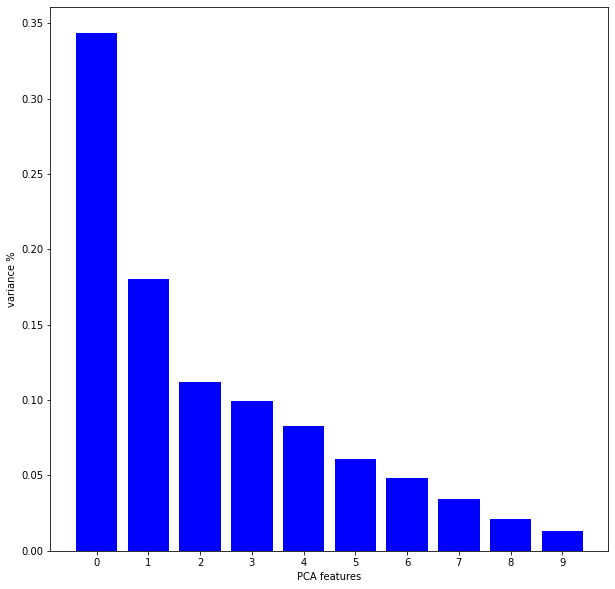

In [281]:
#Create a PCA instance:pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(transformed_df)
#Plot the explained variance
plt.figure(figsize = (10,10))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_ , color = 'blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
#Saving components to a Data Frame 
PCA_components = pd.DataFrame(data = principalComponents , index = df_x_e.index)

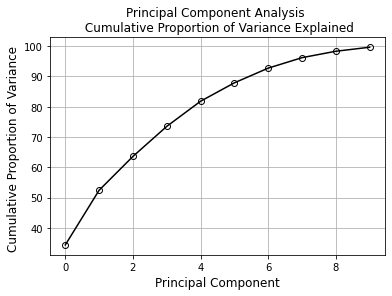

In [283]:
# Assign variance explained
var = pca.explained_variance_ratio_

# Plot cumulative variance
cumulative_var = np.cumsum(var)*100
plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ",fontsize=12)
plt.grid()
plt.show()

From this plot, we see that 6 principal components accounts for >90% of the variance.  
We will be using these components will be used as features for clustering to analyze which regions are similar to StP.  
We note that we have only 81 observations (rows) in our transformed data.  
To avoid overfitting the model, we use only 4 principal components which can account for >80% of the the variance.


Text(0, 0.5, 'PCA 2')

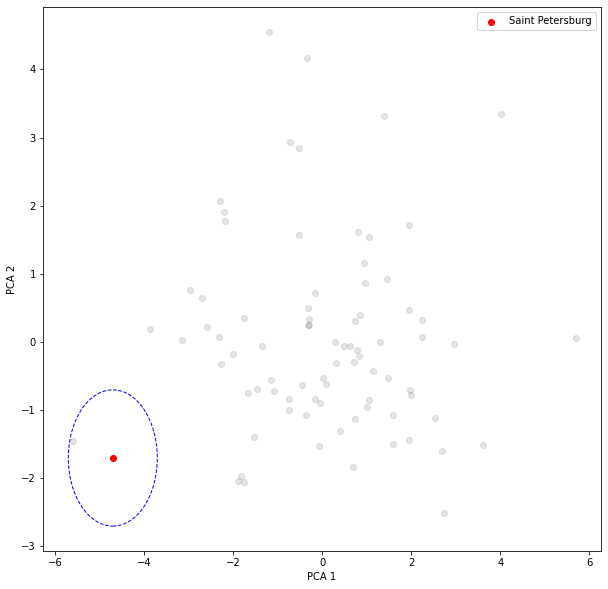

In [287]:
chosen_PCA_components = PCA_components.iloc[:, :3].copy()

plt.figure(figsize = (10,10))
ax = plt.gca()
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.scatter(PCA_components.loc['Saint Petersburg'][0], 
            PCA_components.loc['Saint Petersburg'][1], 
            color = 'red', label = 'Saint Petersburg')
circle = plt.Circle((PCA_components.loc['Saint Petersburg'][0], 
                      PCA_components.loc['Saint Petersburg'][1]), 
                     1, color='b', 
                     ls = '--',
                     fill=False)
ax.add_patch(circle)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

It seems that there are very good candidates that are similar to Saint Petersburg. Anyway, here we use just the 2 most important features, instead of 4, so when we add the remaining features we will get a more accurate result.

## Clustering
Clustering refers to a very set of techniques for finding subgroups in a data set?.  
The goal is that the observation within every group were similar to each other.  
In K-means clustering we look to find K non-overlapping clusters, wherein every group the variation between the cluster members should be small as possible.

One of the problems of this clustering method is to address the question about how many clusters exist?  
Too many clusters should cause overfitting but too little should cause biased conclusions.  
To answer this question one should do an elbow analysis, in which you should choose the number of clusters that gives a high reduction of the inertia ( inertia is a measure of how coherent is every cluster internally).

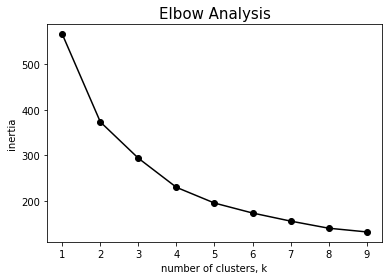

In [288]:

import warnings

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # ignore UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.
        model = KMeans(n_clusters=k)
        model.fit(chosen_PCA_components)
        inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Elbow Analysis', fontsize = 15)
plt.show()

Looking at the elbow analysis, we should conclude that using 4 or 5 clusters would be okay, additional clusters don't reduce the inertia too much.

In [289]:
#Run Kmeans model with 4 cluster
km = KMeans(n_clusters=4) 
km.fit(chosen_PCA_components)
centers = km.cluster_centers_
label = km.predict(chosen_PCA_components)
chosen_PCA_components['label'] = label
sp_label = chosen_PCA_components.loc['Saint Petersburg','label']

In [290]:
# cluster_df = chosen_PCA_components['label'].reset_index()
# cluster_df.columns = ['region', 'cluster']
# cluster_crosstab = pd.crosstab( cluster_df['cluster'], cluster_df['region'],  )

cluster_df = pd.DataFrame({
    'label': label, 
    'region': chosen_PCA_components.index, 
}).sort_values('label')
index = cluster_df[ cluster_df['region'] == 'Saint Petersburg'].index[0]
cluster_df.loc[index:].head(10)


,label,region
58,0,Saint Petersburg
33,0,Moscow Oblast
70,0,Tver Oblast
71,0,Tyumen Oblast
35,0,Nenets Autonomous Okrug
7,0,Chelyabinsk Oblast
76,0,Vologda Oblast
3,0,Arkhangelsk Oblast
78,0,Yamalo-Nenets Autonomous Okrug
34,0,Murmansk Oblast


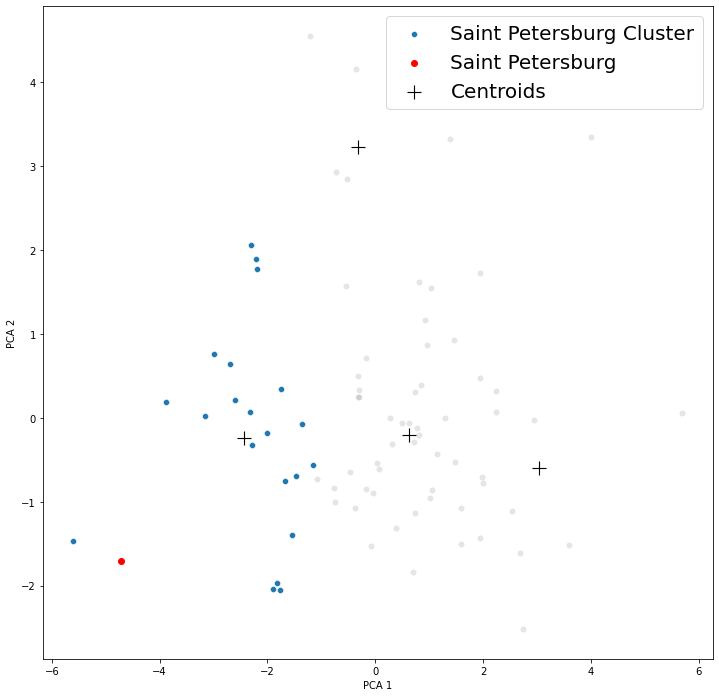

In [291]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=0, y= 1 , 
                data = chosen_PCA_components,
                alpha = 0.1,
                color = 'black')
sns.scatterplot(x=chosen_PCA_components.loc[chosen_PCA_components.label==sp_label][0],
                y=chosen_PCA_components.loc[chosen_PCA_components.label==sp_label][1], 
               label = 'Saint Petersburg Cluster')
plt.scatter(x=chosen_PCA_components.loc['Saint Petersburg'][0],
                y=chosen_PCA_components.loc['Saint Petersburg'][1],
                color = 'red',
           label = 'Saint Petersburg')
sns.scatterplot(x=centers[:,0], y=centers[:,1], 
                marker='+', 
                color='black',
                label ='Centroids',
                s=200);
plt.legend(fontsize=20)
plt.xlabel('PCA 1')
_ = plt.ylabel('PCA 2')

Now that we have the cluster Saint Petersburg with other similar regions, but unfortunately the cluster has more than ten regions. To tackle the objective of this exercise and only pick ten regions, I just select the ten nearest regions to the centroid which belongs to Saint Petersburg.

#Selecting t


In [175]:
#Selecting ten nearest region to centroid 
PCA_components['distance'] = km.transform(PCA_components.iloc[:,:3]).mean(axis=1)
Conclusion= PCA_components[PCA_components.label == sp_label].sort_values('distance').drop(['Saint Petersburg']).index[:10]
pd.DataFrame(Conclusion)

KeyError: "['Saint Petersburg'] not found in axis"

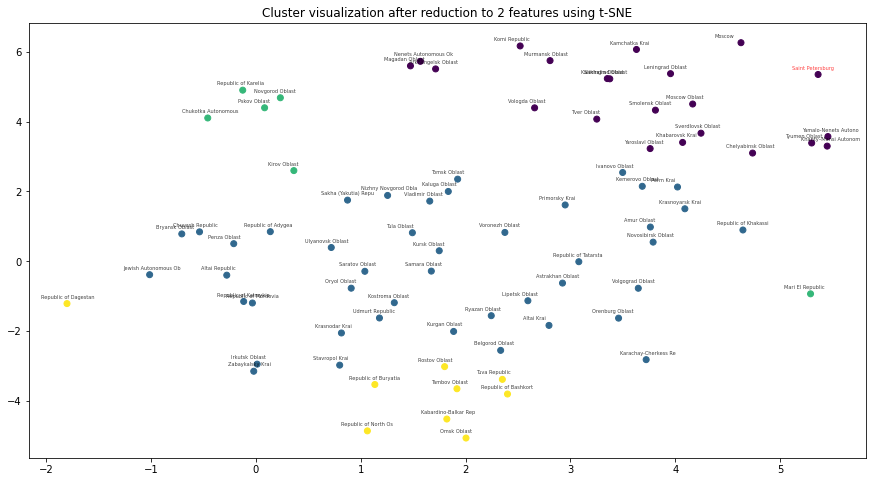

In [292]:
from sklearn.manifold import TSNE 
random_seed=31
model = TSNE(init='random', learning_rate='auto', random_state=random_seed )
tsne_features = model.fit_transform(
    chosen_PCA_components.drop('label', axis=1)
)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
plt.figure( figsize=(15,8))
plt.scatter(
    xs, ys,
    c = chosen_PCA_components['label']
)
plt.title('Cluster visualization after reduction to 2 features using t-SNE')

regions = chosen_PCA_components.index
for x,y,region in zip(xs, ys,regions) :
    if 'Pet' in region :
        color = 'red'
    else :
        color = 'black'
    plt.annotate(region[:20], (x-0.25, y+0.15), alpha=0.75, fontsize=5, color=color, )


T-distributed stochastic neighbor embedding (t-SNE) is a tool that maps high-dimensional data to 2 or 3 dimensions to be visualized.  
Note that the axis of the plot do not have any interpretable meaning.

In [293]:
tsne_df = pd.DataFrame(tsne_features, index=chosen_PCA_components.index)
tsne_df.columns = ['x', 'y']
origin_region_x, origin_region_y = tsne_df.loc['Saint Petersburg']

tsne_df['distance'] = tsne_df.apply( 
    lambda row : (row['x'] - origin_region_x) ** 2 + (row['y'] - origin_region_y) ** 2, 
    axis=1, )
sorted( tsne_df.sort_values('distance')[1:11].index.to_list())

['Kaliningrad Oblast',
 'Kamchatka Krai',
 'Leningrad Oblast',
 'Moscow',
 'Moscow Oblast',
 'Sakhalin Oblast',
 'Smolensk Oblast',
 'Sverdlovsk Oblast',
 'Tyumen Oblast',
 'Yamalo-Nenets Autonomous Okrug']

* Chukotka Autonomous Okrug, 
Tver Oblast, Sverdlovsk Oblast, Kaliningrad Oblast, Yaroslavl Oblast, Pskov Oblast, Primorsky Krai, Republic of Karelia, Kaluga Oblast and Novgorod Oblast.